# Fruit and vegetables image classification with neural networks
In this notebook I compared different neural network models to classify images from Kaggle's [Fruits 360](https://www.kaggle.com/moltean/fruits) dataset.

In this dataset there is a total of 90483 images (size 100x100) splitted in 131 different classes representing different varieties of fruit/vegetables. For the purpose of this notebook, I considered as labels the 10 most frequent types of fruit/vegetable: apple, banana, plum, pepper, cherry, grape, tomato, potato, pear, peach.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

#%cd /content/gdrive/My Drive/Kaggle

#!kaggle datasets download -d moltean/fruits

#%cd /content

zip_path = "/content/gdrive/My Drive/Kaggle/fruits.zip"

!cp "{zip_path}" .

!unzip fruits.zip

!rm fruits.zip

In [ ]:
import os
import cv2
import numpy as np
import random
from imutils import paths
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import zero_one_loss

In [ ]:
# directories
train_dir = "fruits-360/Training"
test_dir = "fruits-360/Test"

# 10 most frequent types
types = ["Apple", "Banana", "Plum", "Pepper", "Cherry", "Grape", "Tomato", "Potato", "Pear", "Peach"]

seed = 123

In [ ]:
# training data
imgs = []
labels = []

# randomly shuffle image paths
img_paths = sorted(list(paths.list_images(train_dir)))
random.seed(seed)
random.shuffle(img_paths)

for img_path in tqdm(img_paths): 
  for t in types:
    if img_path.split(os.path.sep)[-2].split(" ")[0] == t:
      # read img, resize it and append to imgs list
      img = cv2.imread(img_path)
      # using imread() the order of colors is BGR (blue, green, red)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (32, 32))
      imgs.append(img)
      
      # take class label and add it to labels list
      label = img_path.split(os.path.sep)[-2].split(" ")[0]
      labels.append(label)

# rescale to [0, 1]
imgs = np.array(imgs, dtype="float32") / 255.0
labels = np.array(labels)

100%|██████████| 67692/67692 [00:08<00:00, 8171.30it/s]


In [ ]:
# split train set in 80% training and 20% validation
Xtrain, Xval, Ytrain, Yval = train_test_split(imgs, labels, test_size=0.2, random_state=seed)

In [ ]:
print("labels:", np.unique(labels))
print("train data shape:", Xtrain.shape)
print("train labels shape:", Ytrain.shape)
print("val data shape:", Xval.shape)
print("val labels shape:", Yval.shape)

labels: ['Apple' 'Banana' 'Cherry' 'Grape' 'Peach' 'Pear' 'Pepper' 'Plum' 'Potato'
 'Tomato']
train data shape: (26085, 32, 32, 3)
train labels shape: (26085,)
val data shape: (6522, 32, 32, 3)
val labels shape: (6522,)


In [ ]:
# test data
test_imgs = []
test_labels = []

test_img_paths = sorted(list(paths.list_images(test_dir)))

for img_path in tqdm(test_img_paths):
  for t in types:
    if img_path.split(os.path.sep)[-2].split(" ")[0] == t:
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (32, 32))
      test_imgs.append(img)
      
      label = img_path.split(os.path.sep)[-2].split(" ")[0]
      test_labels.append(label)

test_imgs = np.array(test_imgs, dtype="float32") / 255.0
test_labels = np.array(test_labels)

Xtest, Ytest = test_imgs, test_labels

100%|██████████| 22688/22688 [00:02<00:00, 8138.91it/s]


In [ ]:
print(np.unique(test_labels))
print("test data shape:", Xtest.shape)
print("test labels shape:", Ytest.shape)

['Apple' 'Banana' 'Cherry' 'Grape' 'Peach' 'Pear' 'Pepper' 'Plum' 'Potato'
 'Tomato']
test data shape: (10906, 32, 32, 3)
test labels shape: (10906,)


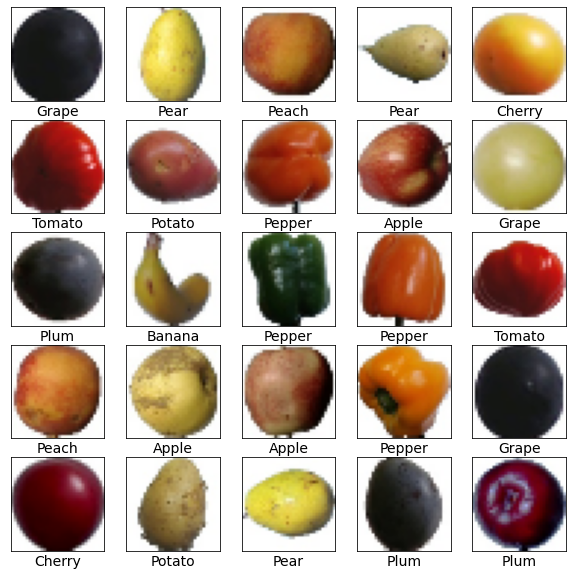

In [ ]:
# visualize some images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Xtrain[i])
    plt.xlabel(Ytrain[i], fontsize=14)
plt.show()

In [ ]:
# one-hot encoding
lb = LabelBinarizer()
Ytrain = lb.fit_transform(Ytrain) # fit_transform finds all unique class labels and transform them in one-hot encoded labels
Yval = lb.transform(Yval) # transform performs one-hot encoding based on classes already found
Ytest = lb.transform(Ytest) 

print("train labels new shape:", Ytrain.shape)
print("val labels new shape:", Yval.shape)
print("test labels new shape:", Ytest.shape)

train labels new shape: (26085, 10)
val labels new shape: (6522, 10)
test labels new shape: (10906, 10)


In [ ]:
# first 5 encoded train labels
Ytrain[0:5]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

# Neural networks
Let's build a vanilla neural network and see how it performs.

In [ ]:
#NN with a Flatten layer and 2 Dense layers
model = Sequential([
  Flatten(input_shape=(32, 32, 3)),
  Dense(32, activation='relu'),
  Dense(32, activation='relu'),
  Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h0 = model.fit(Xtrain, Ytrain,
                    batch_size = 32,
                    validation_data = (Xval, Yval),
                    epochs=5)

Epoch 1/5
816/816 [==============================] - 3s 3ms/step - loss: 1.1808 - accuracy: 0.5714 - val_loss: 0.8356 - val_accuracy: 0.7032
Epoch 2/5
816/816 [==============================] - 3s 3ms/step - loss: 0.7138 - accuracy: 0.7567 - val_loss: 0.6178 - val_accuracy: 0.7981
Epoch 3/5
816/816 [==============================] - 3s 3ms/step - loss: 0.5655 - accuracy: 0.8122 - val_loss: 0.5532 - val_accuracy: 0.8185
Epoch 4/5
816/816 [==============================] - 3s 3ms/step - loss: 0.4882 - accuracy: 0.8395 - val_loss: 0.4767 - val_accuracy: 0.8381
Epoch 5/5
816/816 [==============================] - 2s 3ms/step - loss: 0.4243 - accuracy: 0.8652 - val_loss: 0.4079 - val_accuracy: 0.8654


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                98336     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 99,722
Trainable params: 99,722
Non-trainable params: 0
_________________________________________________________________


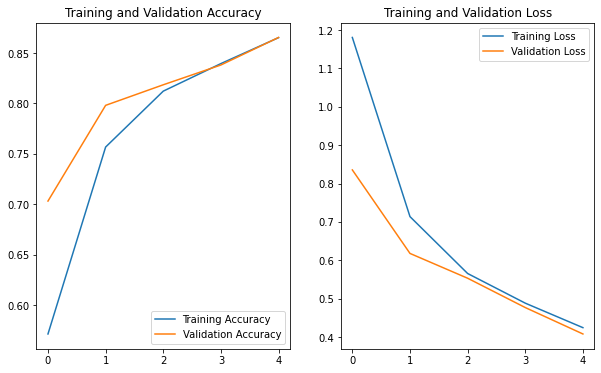

In [ ]:
def plot(hst, epochs):
  acc = hst.history['accuracy']
  val_acc = hst.history['val_accuracy']

  loss=hst.history['loss']
  val_loss=hst.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot(h0,5)

In [ ]:
Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Ytest, axis=1)
print("zero-one loss:", zero_one_loss(y_pred, y_true))

zero-one loss: 0.2913075371355217


After just 5 epochs the model reached 86% of accuracy on training and validation sets, not bad. Looking at test set performance, it scored a zero-one loss of 0.29. Let's see what happens using a different activation function.

In [ ]:
# replacing relu with sigmoid
model = Sequential([
  Flatten(input_shape=(32, 32, 3)),
  Dense(32, activation='sigmoid'),
  Dense(32, activation='sigmoid'),
  Dense(10, activation='softmax'),
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h2 = model.fit(Xtrain, Ytrain,
          batch_size = 32,
          validation_data = (Xval, Yval),
          epochs=5)

Epoch 1/5
816/816 [==============================] - 3s 3ms/step - loss: 1.5306 - accuracy: 0.4894 - val_loss: 1.0417 - val_accuracy: 0.6638
Epoch 2/5
816/816 [==============================] - 3s 3ms/step - loss: 0.7650 - accuracy: 0.7760 - val_loss: 0.5547 - val_accuracy: 0.8654
Epoch 3/5
816/816 [==============================] - 3s 3ms/step - loss: 0.4347 - accuracy: 0.9016 - val_loss: 0.3314 - val_accuracy: 0.9324
Epoch 4/5
816/816 [==============================] - 3s 3ms/step - loss: 0.2537 - accuracy: 0.9500 - val_loss: 0.1951 - val_accuracy: 0.9650
Epoch 5/5
816/816 [==============================] - 3s 3ms/step - loss: 0.1616 - accuracy: 0.9688 - val_loss: 0.1218 - val_accuracy: 0.9752


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                98336     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 99,722
Trainable params: 99,722
Non-trainable params: 0
_________________________________________________________________


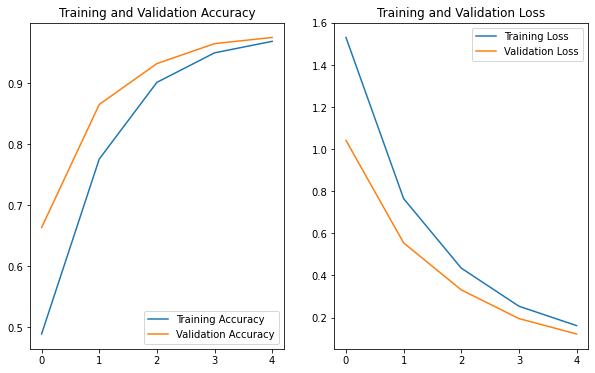

In [ ]:
plot(h2,5)

In [ ]:
Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)
print("zero-one loss:", zero_one_loss(y_pred, y_true))

zero-one loss: 0.16037043829084907


Let's go back to relu and increase the node number to see what happens.

In [ ]:
model = Sequential([
  Flatten(input_shape=(32, 32, 3)),
  Dense(32, activation='relu'),
  Dense(64, activation='relu'),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(10, activation='softmax'),
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h3 = model.fit(Xtrain, Ytrain,
          batch_size = 32,
          validation_data = (Xval, Yval),
          epochs=10)

Epoch 1/10
816/816 [==============================] - 4s 5ms/step - loss: 0.9565 - accuracy: 0.6612 - val_loss: 0.3096 - val_accuracy: 0.8973
Epoch 2/10
816/816 [==============================] - 4s 4ms/step - loss: 0.2942 - accuracy: 0.9025 - val_loss: 0.1413 - val_accuracy: 0.9482
Epoch 3/10
816/816 [==============================] - 4s 4ms/step - loss: 0.1667 - accuracy: 0.9454 - val_loss: 0.0633 - val_accuracy: 0.9801
Epoch 4/10
816/816 [==============================] - 4s 4ms/step - loss: 0.1133 - accuracy: 0.9633 - val_loss: 0.0417 - val_accuracy: 0.9891
Epoch 5/10
816/816 [==============================] - 4s 4ms/step - loss: 0.0925 - accuracy: 0.9686 - val_loss: 0.0318 - val_accuracy: 0.9890
Epoch 6/10
816/816 [==============================] - 4s 4ms/step - loss: 0.0723 - accuracy: 0.9759 - val_loss: 0.0198 - val_accuracy: 0.9929
Epoch 7/10
816/816 [==============================] - 4s 4ms/step - loss: 0.0619 - accuracy: 0.9789 - val_loss: 0.0455 - val_accuracy: 0.9841
Epoch 

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                98336     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 110,058
Trainable params: 110,058
Non-trainable params: 0
________________________________________________

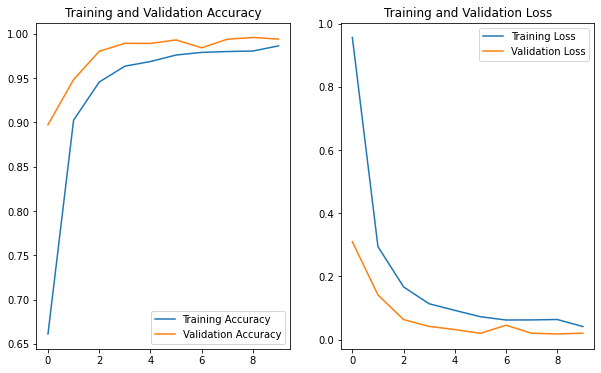

In [ ]:
plot(h3,10)

In [ ]:
Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)
print("zero-one loss:", zero_one_loss(y_pred, y_true))

zero-one loss: 0.06876948468732813


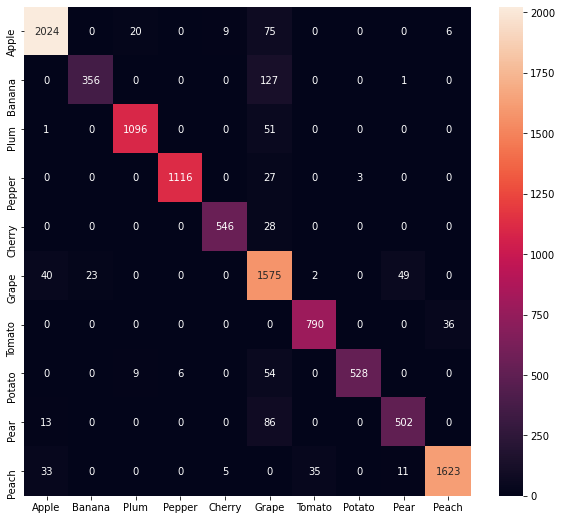

In [ ]:
cm1 = confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(10,9))
sns.heatmap(cm1,annot=True,fmt=".0f")
ax.set_xticklabels(types)
ax.set_yticklabels(types)
plt.show()

So, increasing the number of nodes in each layer made the model perform better "on the field", loss is 0.07.

# Convolutional neural networks
Consider now CNNs, that usually perform better in image classification tasks. Let's start again with a simple structure.

In [ ]:
model = Sequential([
  Conv2D(32, (3,3), input_shape=(32, 32, 3), padding="same", activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h4 = model.fit(Xtrain, Ytrain,
                    batch_size = 32,
                    validation_data = (Xval, Yval),
                    epochs=5)

Epoch 1/5
816/816 [==============================] - 4s 5ms/step - loss: 0.4276 - accuracy: 0.8687 - val_loss: 0.1101 - val_accuracy: 0.9775
Epoch 2/5
816/816 [==============================] - 4s 5ms/step - loss: 0.0568 - accuracy: 0.9899 - val_loss: 0.0323 - val_accuracy: 0.9946
Epoch 3/5
816/816 [==============================] - 4s 5ms/step - loss: 0.0194 - accuracy: 0.9974 - val_loss: 0.0148 - val_accuracy: 0.9969
Epoch 4/5
816/816 [==============================] - 4s 5ms/step - loss: 0.0083 - accuracy: 0.9993 - val_loss: 0.0099 - val_accuracy: 0.9980
Epoch 5/5
816/816 [==============================] - 4s 5ms/step - loss: 0.0061 - accuracy: 0.9992 - val_loss: 0.0054 - val_accuracy: 0.9995


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


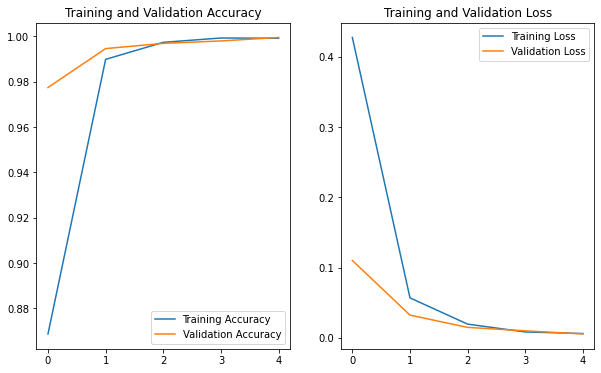

In [ ]:
plot(h4,5)

In [ ]:
Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)
print("zero-one loss:", zero_one_loss(y_pred, y_true))

zero-one loss: 0.0501558774986246


As expected, using even a simple CNN the model improve a lot. Let's now see if we can get further.

In [ ]:
model = Sequential([
  Conv2D(32, (3,3), input_shape=(32, 32, 3), padding="same", activation="relu"),
  Conv2D(32, (3,3), padding="same", activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(64, (3,3), padding="same", activation="relu"),
  Conv2D(64, (3,3), padding="same", activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Dropout(0.5),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h5 = model.fit(Xtrain, Ytrain,
                    batch_size = 32,
                    validation_data = (Xval, Yval),
                    epochs=5)

Epoch 1/5
816/816 [==============================] - 8s 10ms/step - loss: 0.3710 - accuracy: 0.8706 - val_loss: 0.0182 - val_accuracy: 0.9943
Epoch 2/5
816/816 [==============================] - 8s 9ms/step - loss: 0.0413 - accuracy: 0.9858 - val_loss: 0.0187 - val_accuracy: 0.9948
Epoch 3/5
816/816 [==============================] - 8s 9ms/step - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.0087 - val_accuracy: 0.9979
Epoch 4/5
816/816 [==============================] - 8s 10ms/step - loss: 0.0294 - accuracy: 0.9907 - val_loss: 6.3326e-04 - val_accuracy: 1.0000
Epoch 5/5
816/816 [==============================] - 8s 9ms/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.0015 - val_accuracy: 0.9998


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)         

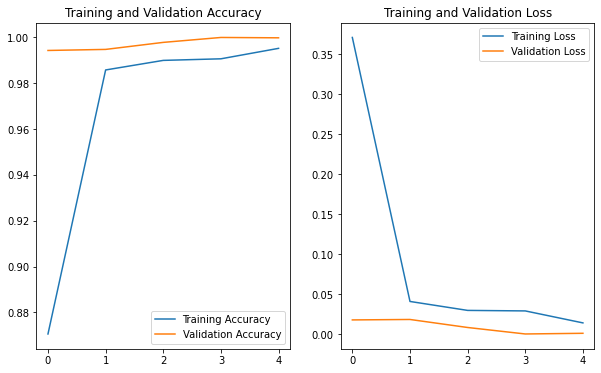

In [ ]:
plot(h5,5)

In [ ]:
Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)
print("zero-one loss:", zero_one_loss(y_pred, y_true))

zero-one loss: 0.011461580781221392


In [ ]:
model = Sequential([
  Conv2D(32, (3,3), input_shape=(32, 32, 3), padding="same"),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(64, (3,3), padding="same"),
  BatchNormalization(),
  #Activation('relu'),
  LeakyReLU(),
  MaxPooling2D(pool_size=(2,2)),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  #Dropout(0.2),
  Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h6 = model.fit(Xtrain, Ytrain,
               batch_size = 32,
               validation_data = (Xval, Yval),
               epochs=10)

Epoch 1/10
816/816 [==============================] - 4s 5ms/step - loss: 0.2199 - accuracy: 0.9348 - val_loss: 0.5296 - val_accuracy: 0.8760
Epoch 2/10
816/816 [==============================] - 3s 4ms/step - loss: 0.0284 - accuracy: 0.9915 - val_loss: 0.0798 - val_accuracy: 0.9683
Epoch 3/10
816/816 [==============================] - 4s 4ms/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 4/10
816/816 [==============================] - 4s 4ms/step - loss: 0.0152 - accuracy: 0.9959 - val_loss: 0.0363 - val_accuracy: 0.9867
Epoch 5/10
816/816 [==============================] - 3s 4ms/step - loss: 0.0177 - accuracy: 0.9950 - val_loss: 0.0721 - val_accuracy: 0.9703
Epoch 6/10
816/816 [==============================] - 4s 4ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 2.8179e-04 - val_accuracy: 1.0000
Epoch 7/10
816/816 [==============================] - 4s 4ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 9.3208e-06 - val_accuracy: 1.000

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 64)      

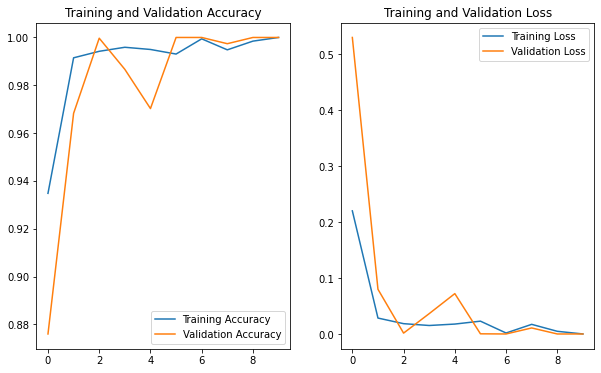

In [ ]:
plot(h6,10)

In [ ]:
Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)
print("zero-one loss:", zero_one_loss(y_pred, y_true))

zero-one loss: 0.006051714652484885


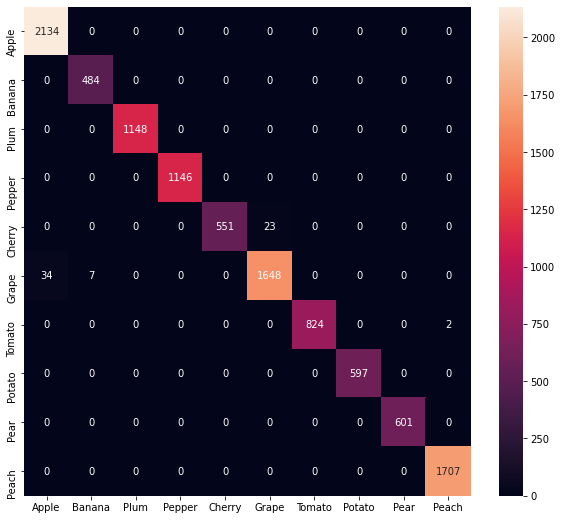

In [ ]:
cm1 = confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(10,9))
sns.heatmap(cm1,annot=True,fmt=".0f")
ax.set_xticklabels(types)
ax.set_yticklabels(types)
plt.show()